# Deep Reinforcement Learning for Multi-Echelon Supply Chain Optimization

This is a tutorial on multi-echelon inventory optimization (MEIO) using reinforcement learning. We define an environment with a factory and several warehouses and show how the Deep Deterministic Policy Gradient (DDPG) algorithm can be used to implement the production and replenishment policy.

Here is the link to the git folder of this work:
https://github.com/Monthaonos/MEIO-lab-class

(This tutorial was transfered from .ipynb to .py and slightly updated by Antoine Germain (agermain@mit.edu) in July 2024. See license file to learn more about licenses of the work. Here is the original .ipynb document, which has been modified in this folder:)
https://github.com/ikatsov/tensor-house/blob/master/supply-chain/supply-chain-reinforcement-learning.ipynb

### Data
We use an internal simulator. No external datasets are used.

### References
1. Kemmer L., et al. -- Reinforcement learning for supply chain optimization, 2018

# Run the file

To run either the .py or the .ipynb file, please follow these steps using a bash terminal and making MEIO your working folder:

### Conda environment and rllib-ddpg

Type the following lines one by one in your bash terminal:

```
conda create -n rllib-ddpg python=3.10
conda activate rllib-ddpg
cd ddpg
pip install -r requirements.txt
pip install -e '.[development]'
cd ..
```

If you get a message telling you "CondaError: Run 'conda init' before 'conda activate'", you might need to write 
```
source activate base
``` 
before activating the rllib-ddpg folder.

### Other libraries
```
pip install qbstyles ray[rllib] ax-platform
pip install seaborn
pip install pandas
conda uninstall pytorch
conda install pytorch torchvision torchaudio pytorch-cuda=11.8 -c pytorch -c nvidia
```

### Running the .py

```
python MEIO.py
```

### Running the .ipynb file

After writting the previous steps in the bash terminal, just press the Run All button or run the cells one by one.

# Imports

In [52]:
import math 
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import pandas as pd
from IPython.display import display
import collections
import json

from qbstyles import mpl_style

mpl_style(dark=False)

from ax import optimize

# Defining the Supply Chain Environment

##### Class State

- init method: Initializes the state with:
    - warehouse_num: Number of warehouses.
    - T: Total duration of the episode.
    - demand_history: Previous demands.
    - t: Current time step.

- to_array method: Converts the state to a numpy array including factory stock, warehouse stock, demand history, and current time.

- stock_levels method: Returns the current stock levels at the factory and warehouses as a numpy array.

##### Class Action

- init method: Initializes an action with:
    - production_level: Level of production at the factory.
    - shippings_to_warehouses: Array of shipments to each warehouse.

##### Class SupplyChainEnvironment

- init method: Sets up the environment with:
    - T: Duration of an episode.
    - warehouse_num: Number of warehouses.
    - d_max and d_var: Maximum demand and its variation.
    - unit_price and unit_cost: Price and cost per unit.
    - storage_capacities: Storage capacities for factory and warehouses.
    - storage_costs and transporation_costs: Costs related to storage and transportation.
    - penalty_unit_cost: Penalty cost for unmet demand.
    - Calls reset to initialize the environment.

- reset method: Resets the demand history and time step.

- demand method: Calculates demand at a given warehouse and time using a sinusoidal pattern with randomness.

- initial_state method: Returns the initial state with the current demand history.

- step method: Executes an action to update the state:
    - Calculates demand for each warehouse.
    - Computes reward based on revenue, costs, and penalties.
    - Updates the next state by adjusting stock levels.
    - Updates demand history and time step.
    - Returns the new state, reward, and a boolean indicating if the episode is done.

In [53]:
class State(object):
    def __init__(self, warehouse_num, T, demand_history, t = 0):
        self.warehouse_num = warehouse_num
        self.factory_stock = 0
        self.warehouse_stock = np.repeat(0, warehouse_num)
        self.demand_history = demand_history
        self.T = T
        self.t = t

    def to_array(self):
        return np.concatenate( ([self.factory_stock], self.warehouse_stock, np.hstack(self.demand_history), [self.t]) )

    def stock_levels(self):
        return np.concatenate( ([self.factory_stock], self.warehouse_stock) )

class Action(object):
    def __init__(self, warehouse_num):
        self.production_level = 0
        self.shippings_to_warehouses = np.zeros(warehouse_num)

class SupplyChainEnvironment(object):
    def __init__(self):
        self.T = 26               # episode duration
        self.warehouse_num = 3  
        self.d_max = 5            # maximum demand, units
        self.d_var = 2            # maximum random demand variation, units 
    
        self.unit_price = 100     # unit price in dollars
        self.unit_cost = 40       # unit cost in dollars

        self.storage_capacities = np.fromfunction(lambda j: 10*(j+1), (self.warehouse_num + 1,), dtype=int)

        self.storage_costs = np.fromfunction(lambda j: 2*(j+1), (self.warehouse_num + 1,), dtype=int)           # storage costs at the factory and each warehouse, dollars per unit
        self.transporation_costs = np.fromfunction(lambda j: 5*(j+1), (self.warehouse_num,), dtype=int)       # transportation costs for each warehouse, dollars per unit
        self.penalty_unit_cost = self.unit_price
        
        self.reset()

    def reset(self, demand_history_len = 4):
        self.demand_history = collections.deque(maxlen = demand_history_len)
        for i in range(demand_history_len):
            self.demand_history.append( np.zeros(self.warehouse_num) )
        self.t = 0

    # demand at time t at warehouse j
    def demand(self, j, t):
        return np.round(self.d_max/2 + self.d_max/2*np.sin(2*np.pi*(t + 2*j)/self.T*2) + np.random.randint(0, self.d_var))

    def initial_state(self):
        return State(self.warehouse_num, self.T, list(self.demand_history))

    def step(self, state, action):
        demands = np.fromfunction(lambda j: self.demand(j+1, self.t), (self.warehouse_num,), dtype=int)
    
        # calculating the reward (profit)
        total_revenue = self.unit_price * np.sum(demands)
        total_production_cost = self.unit_cost * action.production_level
        total_storage_cost = np.dot( self.storage_costs, np.maximum(state.stock_levels(), np.zeros(self.warehouse_num + 1)) )
        total_penalty_cost = - self.penalty_unit_cost * ( np.sum( np.minimum(state.warehouse_stock, np.zeros(self.warehouse_num)) )  +  min(state.factory_stock, 0))
        total_transportation_cost = np.dot( self.transporation_costs, action.shippings_to_warehouses )
        reward = total_revenue - total_production_cost - total_storage_cost - total_penalty_cost - total_transportation_cost

        # calculating the next state
        next_state = State(self.warehouse_num, self.T, self.t)
        next_state.factory_stock = min(state.factory_stock + action.production_level - np.sum(action.shippings_to_warehouses), self.storage_capacities[0]) 
        for w in range(self.warehouse_num):
            next_state.warehouse_stock[w] = min(state.warehouse_stock[w] + action.shippings_to_warehouses[w] - demands[w], self.storage_capacities[w+1])    
        next_state.demand_history = list(self.demand_history)

        self.t += 1
        self.demand_history.append(demands)

        return next_state, reward, self.t == self.T - 1


### Initialization

- env = SupplyChainEnvironment() creates an instance of the environment.

- demands = np.fromfunction(lambda j, t: env.demand(j, t), (env.warehouse_num, env.T), dtype=int) calculates the demand for each warehouse over time using the demand function.

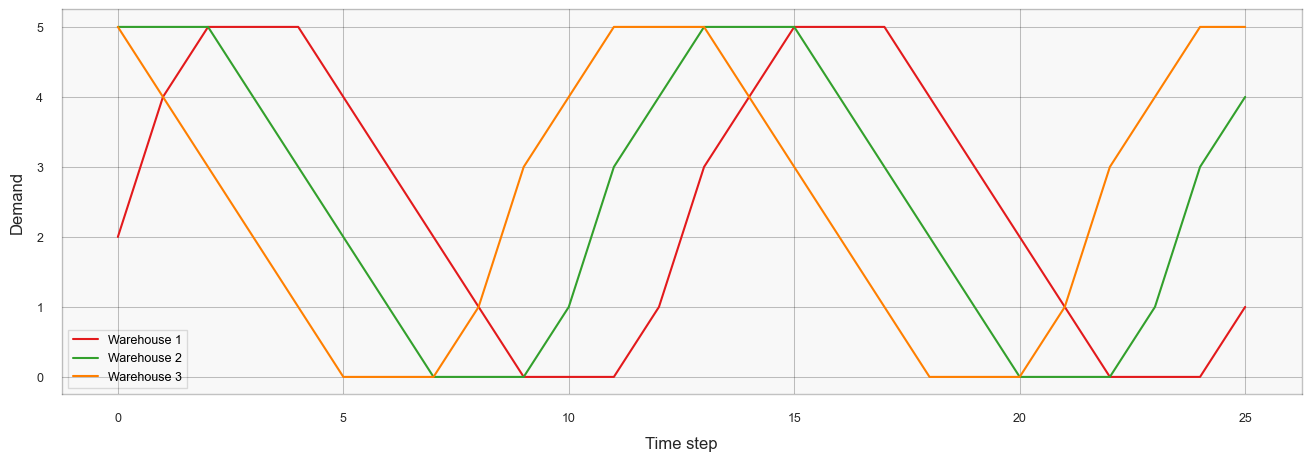

In [54]:
# visualize demand functions for warehouses
env = SupplyChainEnvironment()
demands = np.fromfunction(lambda j, t: env.demand(j, t), (env.warehouse_num, env.T), dtype=int)
plt.figure(figsize=(16, 5))
plt.xlabel("Time step")
plt.ylabel("Demand")
plt.plot(range(env.T), demands.T)
plt.legend([f'Warehouse {i+1}' for i in range(env.warehouse_num)])

# Common Functions and Visualization

##### Functions

- prepare_metric_plot: sets up a subplot within a figure.

- visualize_transitions: visualizes different metrics over an episode.

In [55]:
def prepare_metric_plot(plots_n, n, ylabel):
    plt.subplot(plots_n, 1, n)
    plt.ylabel(ylabel)
    plt.tick_params(axis='x', which='both', bottom=True, top=True, labelbottom=False)

# visualizing one episode - stock levels, production and reorderign actions, and rewards
def visualize_transitions(transitions):
    state_trace, action_trace, reward_trace = (transitions.T[0], transitions.T[1], transitions.T[2])
    plots_n = 10
    mpl.rcParams['lines.linewidth'] = 2    
    print(f"Return is {sum(reward_trace)}")

    fig = plt.figure(figsize=(8, 12))
    prepare_metric_plot(plots_n, 1, "Stock,\n Factory")
    plt.plot(range(env.T), list(map(lambda s: s.factory_stock, state_trace)), c='purple', alpha=0.5)

    for w in range(env.warehouse_num):
        prepare_metric_plot(plots_n, 2 + w, f"Stock,\n WH {w+1}")
        plt.plot(range(env.T), list(map(lambda s: s.warehouse_stock[w], state_trace)), c='purple', alpha=0.5)
    
    prepare_metric_plot(plots_n, 5, "Production")
    plt.plot(range(env.T), list(map(lambda a: a.production_level, action_trace)), c='blue', alpha=0.5)

    for w in range(env.warehouse_num):
        prepare_metric_plot(plots_n, 6 + w, f"Shipment,\n WH {w+1}")
        plt.plot(range(env.T), list(map(lambda a: a.shippings_to_warehouses[w], action_trace)), c='blue', alpha=0.5)
    
    prepare_metric_plot(plots_n, 9, "Profit")
    plt.plot(range(env.T), reward_trace, c='red', alpha=0.9, linewidth=2)

    plt.subplot(plots_n, 1, 10)
    plt.ylabel("Cumulative\nprofit")
    plt.ylim(0, 10000)
    plt.plot(range(env.T), np.cumsum(reward_trace), c='red', alpha=0.9, linewidth=2)
    plt.xlabel("Time step")

# Baseline Policy - (s,Q)

### Simulation functions

##### Class SQPolicy

Implements an (s, Q) policy for inventory management.

- init method:
    - factory_safety_stock: Minimum stock level before ordering at the factory.
    - factory_reorder_amount: Quantity to reorder at the factory.
    - safety_stock: Array of safety stock levels for each warehouse.
    - reorder_amount: Array of reorder quantities for each warehouse.

- select_action method:
    - Creates an Action object.
    - For each warehouse: if the stock is below safety_stock, set the reorder amount.
    - For the factory: if stock minus shipments is below factory_safety_stock, set production_level to reorder amount.
    - Returns the configured action.

##### Functions

- simulate_episode: simulates a single episode of the supply chain:

    - Initializes the state.
    - Iterates over each time step:
    - Uses the policy to select an action.
    - Applies the action in the environment, obtaining the next state and reward.
    - Stores transitions of state, action, and reward.
    - Returns the list of transitions.
    
- simulate: runs multiple episodes to evaluate the policy:

    - Initializes a list to store returns for each episode.
    - For each episode:
    - Resets the environment.
    - Simulates an episode and calculates the total reward.
    - Appends the total reward to returns_trace.
    - Returns the list of episode returns.

In [56]:
# We use (s, Q)-policy as a baseline 
# The policy is: Order your Economic Order Quantity Q, every time your inventory 
# position drops below s (Reorder Point or Safety Stock).

class SQPolicy(object):
    def __init__(self, factory_safety_stock, factory_reorder_amount, safety_stock, reorder_amount):
        self.factory_safety_stock = factory_safety_stock
        self.factory_reorder_amount = factory_reorder_amount
        self.safety_stock = safety_stock
        self.reorder_amount = reorder_amount

    def select_action(self, state):
        action = Action(state.warehouse_num)
        for w in range(state.warehouse_num):
            if state.warehouse_stock[w] < self.safety_stock[w]:
                action.shippings_to_warehouses[w] = self.reorder_amount[w]
    
        if state.factory_stock - np.sum(action.shippings_to_warehouses) < self.factory_safety_stock: 
            action.production_level = self.factory_reorder_amount
        else: 
            action.production_level = 0
        return action
    
def simulate_episode(env, policy):
    state = env.initial_state()
    transitions = []
    for t in range(env.T):
        action = policy.select_action(state)
        state, reward, _ = env.step(state, action)
        transitions.append([state, action, reward])
    return transitions

# basic policy evaluation process 
def simulate(env, policy, num_episodes):
    returns_trace = []
    for episode in range(num_episodes):
        env.reset()
        returns_trace.append( sum(np.array(simulate_episode(env, policy)).T[2]) )
    return returns_trace

### Optimization of (s, Q)-policy parameters using brute force search

Here we define a grid of parameters to explore with brute force, create an environment, and keep the best configuration among the grid defined earlier.

In [66]:
from sklearn.model_selection import ParameterGrid

p_grid1 = [5, 10, 20]
p_grid2 = [5, 10, 20]
param_grid = {
    'factory_s': p_grid1, 
    'factory_Q': p_grid1,
    'w1_s': p_grid2,
    'w2_s': p_grid2,
    'w3_s': p_grid2,
    'w1_Q': p_grid2,
    'w2_Q': p_grid2,
    'w3_Q': p_grid2,
    }

env = SupplyChainEnvironment()
grid = ParameterGrid(param_grid)
i = 0
best_return = float('-inf')
for p in grid:
    policy = SQPolicy(
        p['factory_s'], p['factory_Q'],
        [ p['w1_s'], p['w2_s'], p['w3_s'], ],
        [ p['w1_Q'], p['w2_Q'], p['w3_Q'], ]
    )
    m_return = np.mean(simulate(env, policy, num_episodes = 10))
    if m_return > best_return:
        best_return = m_return
        best_params = p

    if i % 100 == 0:
        print(f"Configuration #{i} -- {best_return}")
    i += 1

Configuration #0 -- -143230.9
Configuration #100 -- -143230.9
Configuration #200 -- -143230.9
Configuration #300 -- -143230.9
Configuration #400 -- -143230.9
Configuration #500 -- -143230.9
Configuration #600 -- -143230.9
Configuration #700 -- -143230.9
Configuration #800 -- -141103.3
Configuration #900 -- -141103.3
Configuration #1000 -- -141103.3
Configuration #1100 -- -141103.3
Configuration #1200 -- -141103.3
Configuration #1300 -- -141103.3
Configuration #1400 -- -141103.3
Configuration #1500 -- -139840.6
Configuration #1600 -- -139840.6
Configuration #1700 -- -139840.6
Configuration #1800 -- -139840.6
Configuration #1900 -- -139840.6
Configuration #2000 -- -139840.6
Configuration #2100 -- -139840.6
Configuration #2200 -- -4229.7
Configuration #2300 -- -3598.5
Configuration #2400 -- -3598.5
Configuration #2500 -- -3598.5
Configuration #2600 -- -3598.5
Configuration #2700 -- -3598.5
Configuration #2800 -- -3598.5
Configuration #2900 -- -3598.5
Configuration #3000 -- -1063.3
Configu

### Optimizing (s, Q)-policy parameters using Facebook Ax

- func: evaluates the performance of an (s, Q) policy:
    - Creates an SQPolicy with parameters from p.
    - Simulates the environment using the policy over 30 episodes.
    - Returns the average reward.

This setup is used to find the optimal (s, Q) policy parameters to maximize the average reward (profit) in the supply chain environment.

In [57]:
# from ax import optimize

def func(p):
    policy = SQPolicy(
        p['factory_s'],
        p['factory_Q'],
        [ p['w1_s'], p['w2_s'], p['w3_s'], ],
        [ p['w1_Q'], p['w2_Q'], p['w3_Q'], ]
    )
    return np.mean(simulate(env, policy, num_episodes = 30))

best_parameters, best_values, experiment, model = optimize(
        parameters=[
          { "name": "factory_s",   "type": "range",  "bounds": [0.0, 30.0], },
          { "name": "factory_Q",   "type": "range",  "bounds": [0.0, 30.0], },
          { "name": "w1_s",        "type": "range",  "bounds": [0.0, 20.0], },
          { "name": "w1_Q",        "type": "range",  "bounds": [0.0, 20.0], },  
          { "name": "w2_s",        "type": "range",  "bounds": [0.0, 20.0], },
          { "name": "w2_Q",        "type": "range",  "bounds": [0.0, 20.0], },    
          { "name": "w3_s",        "type": "range",  "bounds": [0.0, 20.0], },
          { "name": "w3_Q",        "type": "range",  "bounds": [0.0, 20.0], },    
        ],
        evaluation_function=func,
        minimize=False,
        total_trials=20,
    )

[INFO 07-31 08:47:51] ax.service.utils.instantiation: Inferred value type of ParameterType.FLOAT for parameter factory_s. If that is not the expected value type, you can explicitly specify 'value_type' ('int', 'float', 'bool' or 'str') in parameter dict.
[INFO 07-31 08:47:51] ax.service.utils.instantiation: Inferred value type of ParameterType.FLOAT for parameter factory_Q. If that is not the expected value type, you can explicitly specify 'value_type' ('int', 'float', 'bool' or 'str') in parameter dict.
[INFO 07-31 08:47:51] ax.service.utils.instantiation: Inferred value type of ParameterType.FLOAT for parameter w1_s. If that is not the expected value type, you can explicitly specify 'value_type' ('int', 'float', 'bool' or 'str') in parameter dict.
[INFO 07-31 08:47:51] ax.service.utils.instantiation: Inferred value type of ParameterType.FLOAT for parameter w1_Q. If that is not the expected value type, you can explicitly specify 'value_type' ('int', 'float', 'bool' or 'str') in parame

In [58]:
display(best_parameters)
display(best_values)

{'factory_s': 11.991217438726387,
 'factory_Q': 16.543008154403964,
 'w1_s': 5.995760533181271,
 'w1_Q': 6.506626124667358,
 'w2_s': 12.674940262528846,
 'w2_Q': 14.102090998899735,
 'w3_s': 4.716080967876551,
 'w3_Q': 9.235156620638783}

({'objective': -6740.110811692153},
 {'objective': {'objective': 176078327.93454453}})

Reward: mean 7244.78, standard deviation 686.6285106227384


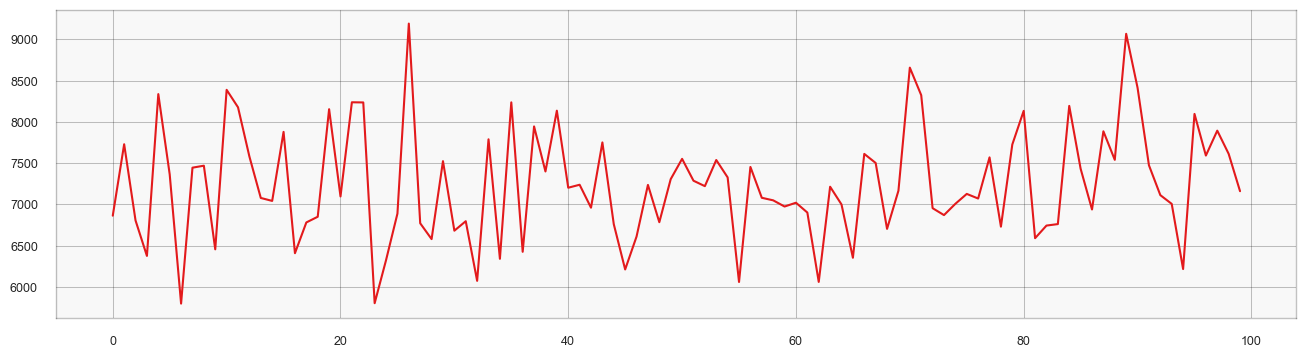

In [59]:
# evaluating the winning (s,Q) policy more accurately
env = SupplyChainEnvironment()
policy_sQ = SQPolicy(0.0, 20.0, [5, 5, 5], [5, 5, 10])
return_trace = simulate(env, policy_sQ, num_episodes = 100)
plt.figure(figsize=(16, 4))
plt.plot(range(len(return_trace)), return_trace)
print(f"Reward: mean {np.mean(return_trace)}, standard deviation {np.std(return_trace)}")

Return is 7644.0


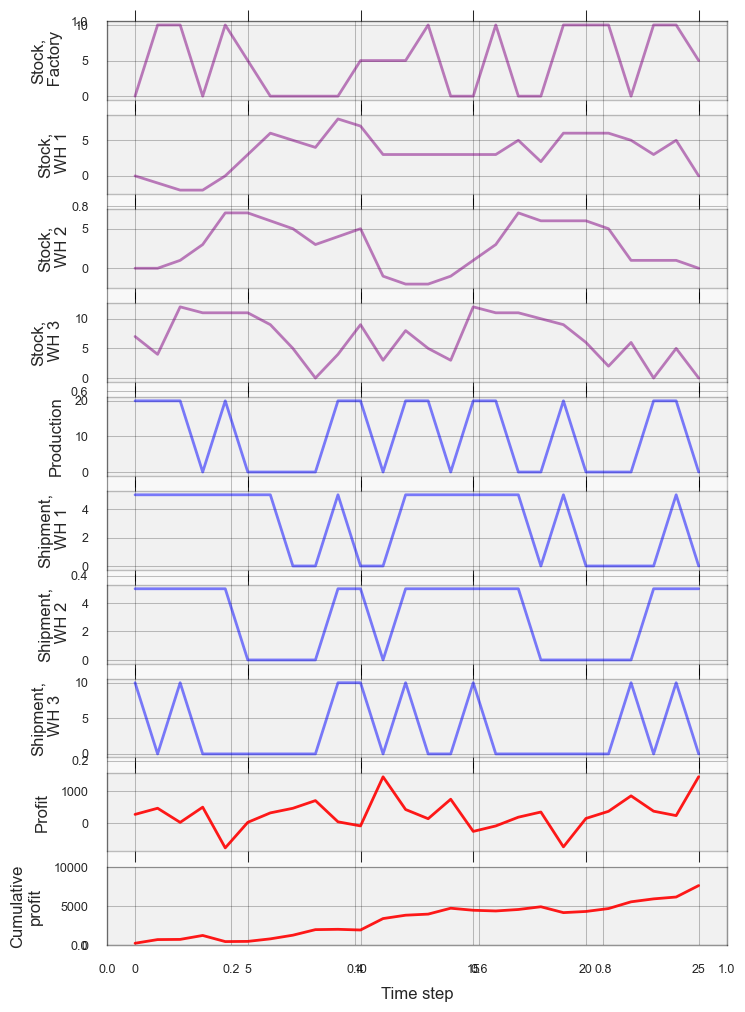

In [60]:
# tracing the winning (s,Q)  policy
env = SupplyChainEnvironment()
transitions_sQ = simulate_episode(env, policy_sQ)
visualize_transitions(np.array(transitions_sQ))

# Optimizing the Policy Using Reinforcement Learning / RLlib

- Class SimpleSupplyChain: creates a gym environment and reset and step functions:
    - init: initializes the environment, setting the action and observation spaces.
    - reset: resets the environment to its initial state and returns the initial state array.
    - step: takes an action, updates the environment state, and returns the new state, reward, and done flag.

##### Functions

- train_ddpg: configures and trains a DDPG algorithm:
    - Configuration:
    - rollouts: sets the number of rollout workers.
    - resources: sets the number of GPUs.
    - training: sets various training parameters like discount factor gamma, hidden layers, and target network update frequency.
    - environment: Specifies the custom Gym environment SimpleSupplyChain.
    - Training Loop:
    - runs for 20 iterations, training the model and saving checkpoints.
    - prints the training results and checkpoint directories.

In [64]:
import argparse

from rllib_ddpg.ddpg import DDPG, DDPGConfig
import ray
from ray import air, tune
from ray.rllib.utils.test_utils import check_learning_achieved
import numpy as np
import gymnasium as gym
from gymnasium.spaces import Box
from gymnasium.wrappers import EnvCompatibility
import ray
from ray import tune
from ray.rllib.utils import try_import_tf
from ray.tune.logger import pretty_print
from ray.tune.registry import register_env

tf = try_import_tf()

# gym environment adapter
class SimpleSupplyChain(gym.Env):
    def __init__(self, config):
        self.reset()
        self.action_space = Box(low=0.0, high=20.0, shape=(self.supply_chain.warehouse_num + 1, ), dtype=np.int16)
        self.observation_space = Box(-10000, 10000, shape=(len(self.supply_chain.initial_state().to_array()), ), dtype=np.float32)

    def reset(self, *, seed=None, options=None):
        self.supply_chain = SupplyChainEnvironment()
        self.state = self.supply_chain.initial_state()
        return self.state.to_array(), {}

    def step(self, action):
        action_obj = Action(self.supply_chain.warehouse_num)
        action_obj.production_level = action[0]
        action_obj.shippings_to_warehouses = action[1:]
        self.state, reward, done = self.supply_chain.step(self.state, action_obj)
        return self.state.to_array(), reward, False, done, {}

ray.shutdown()
ray.init()

def train_ddpg():
    algo = (
      DDPGConfig()
      .rollouts(num_rollout_workers=1)
      .resources(num_gpus=0)
      .training(gamma=0.95, 
                actor_hiddens=[512, 512], 
                critic_hiddens=[512, 512],
                target_network_update_freq=5)

      .environment(env=SimpleSupplyChain)
      .build()
    )
    #config = ddpg.DEFAULT_CONFIG.copy()
    #algo["log_level"] = "WARN"
    #algo["actor_hiddens"] = [512, 512] 
    #algo["critic_hiddens"] = [512, 512]
    #algo["gamma"] = 0.95
    #algo["timesteps_per_iteration"] = 1000
    #algo["target_network_update_freq"] = 5
    #algo["buffer_size"] = 10000
    
    for i in range(2):
        print(i)
        result = algo.train()
        print(pretty_print(result))
        checkpoint_dir = algo.save()
        print("Checkpoint saved at", checkpoint_dir)
    return checkpoint_dir

# We keep in memory the path to the last checkpoint training file
checkpoint_dir=train_ddpg()

2024-07-31 08:59:16,445	INFO worker.py:1636 -- Started a local Ray instance.
c:\Users\germa\anaconda3\envs\rllib-ddpg\lib\site-packages\ray\rllib\algorithms\algorithm.py:442: RayDeprecationWarning: This API is deprecated and may be removed in future Ray releases. You could suppress this warning by setting env variable PYTHONWARNINGS="ignore::DeprecationWarning"
`UnifiedLogger` will be removed in Ray 2.7.
  return UnifiedLogger(config, logdir, loggers=None)
c:\Users\germa\anaconda3\envs\rllib-ddpg\lib\site-packages\ray\tune\logger\unified.py:53: RayDeprecationWarning: This API is deprecated and may be removed in future Ray releases. You could suppress this warning by setting env variable PYTHONWARNINGS="ignore::DeprecationWarning"
The `JsonLogger interface is deprecated in favor of the `ray.tune.json.JsonLoggerCallback` interface and will be removed in Ray 2.7.
  self._loggers.append(cls(self.config, self.logdir, self.trial))
c:\Users\germa\anaconda3\envs\rllib-ddpg\lib\site-packages\ra

0
agent_timesteps_total: 1000
connector_metrics:
  ObsPreprocessorConnector_ms: 0.0
  StateBufferConnector_ms: 0.002518892288208008
  ViewRequirementAgentConnector_ms: 0.127524733543396
counters:
  num_agent_steps_sampled: 1000
  num_agent_steps_trained: 0
  num_env_steps_sampled: 1000
  num_env_steps_trained: 0
custom_metrics: {}
date: 2024-07-31_09-02-17
done: false
episode_len_mean: 25.0
episode_media: {}
episode_reward_max: -423877.0
episode_reward_mean: -602676.2
episode_reward_min: -733904.0
episodes_this_iter: 40
episodes_total: 40
hostname: MSI
info:
  learner: {}
  num_agent_steps_sampled: 1000
  num_agent_steps_trained: 0
  num_env_steps_sampled: 1000
  num_env_steps_trained: 0
iterations_since_restore: 1
node_ip: 127.0.0.1
num_agent_steps_sampled: 1000
num_agent_steps_trained: 0
num_env_steps_sampled: 1000
num_env_steps_sampled_this_iter: 1000
num_env_steps_sampled_throughput_per_sec: 155.4751802273035
num_env_steps_trained: 0
num_env_steps_trained_this_iter: 0
num_env_steps

# Analysis and Debugging of the Policy Produced by RLlib

First we configures the DDPG algorithm with rollouts, resources, training, environment.
We then load the previously obtained policy.

Finally, we create transitions_rl, an empty list to store the transitions (state, action, reward) during the episode and iterate over the time steps t from 0 to env.T (episode duration). 
We compute an action using the current state array, set the production_level and shippings_to_warehouses attributes of the action_obj using the computed action values and execute the action in the environment, updating the state and returning the reward and a flag indicating if the episode is done.

In [65]:
import json
# checkpoint_dir = cwd+'/ray_results/DDPG_SimpleSupplyChain_test/'
algo = (
  DDPGConfig()
  .rollouts(num_rollout_workers=1)
  .resources(num_gpus=0)
  .training(gamma=0.95, 
            actor_hiddens=[512, 512], 
            critic_hiddens=[512, 512],
            target_network_update_freq=5)

  .environment(env=SimpleSupplyChain)
  .build()
)

def load_policy(): 
    algo.restore(checkpoint_dir)
    return algo.get_policy()

policy = load_policy()

# tracing the policy
env = SupplyChainEnvironment()
state = env.initial_state()
transitions_rl = []
for t in range(env.T):
    action = policy.compute_single_action( state.to_array() , state=[] ) 
    action_obj = Action(env.warehouse_num)
    action_obj.production_level = action[0][0]
    action_obj.shippings_to_warehouses = action[0][1:]
    state, reward, _ = env.step(state, action_obj)
    transitions_rl.append([state, action_obj, reward])

(RolloutWorker pid=39104) 2024-07-31 09:05:14,469	WARNING env.py:155 -- Your env doesn't have a .spec.max_episode_steps attribute. Your horizon will default to infinity, and your environment will not be reset.


2024-07-31 09:05:15,460	INFO trainable.py:173 -- Trainable.setup took 14.168 seconds. If your trainable is slow to initialize, consider setting reuse_actors=True to reduce actor creation overheads.
2024-07-31 09:05:15,463	WARNING util.py:68 -- Install gputil for GPU system monitoring.
2024-07-31 09:05:15,565	INFO trainable.py:918 -- Restored on 127.0.0.1 from checkpoint: C:\Users\germa\ray_results\DDPG_SimpleSupplyChain_2024-07-31_08-59-22bc4yjvd_\checkpoint_000002
2024-07-31 09:05:15,565	INFO trainable.py:927 -- Current state after restoring: {'_iteration': 2, '_timesteps_total': None, '_time_total': 62.55388569831848, '_episodes_total': 80}


Return is -13216.354830481348


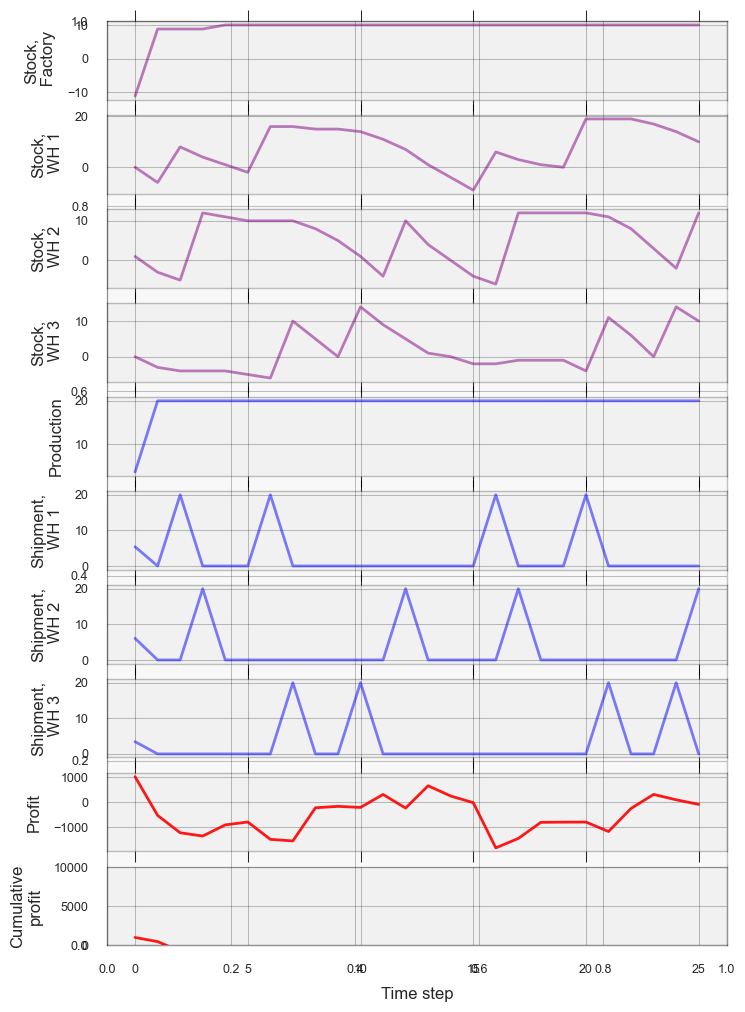

In [ ]:
# tracing the policy
visualize_transitions(np.array(transitions_rl))

# Your turn

Using the function defined above and the packages introduced:

- Brute force search:
    - modify the code of the brute force search below in order to print at the end the parameters of the best return achieved ;
    - once the parameters obtained, make 10 simulations and calculate the average return over these.
    - use the ax optimize results in order to get a better average return with brute fore search by modifying the grids. You might want to create more than the 2 grids already defined, but do not make the grids too long to keep a reasonable calculation time. You should easily reach a best return of 6 500.

In [ ]:
from sklearn.model_selection import ParameterGrid

p_grid1 = [10, 14, 18]
p_grid2 = [5, 10, 20]
param_grid = {
    'factory_s': p_grid1, 
    'factory_Q': p_grid1,
    'w1_s': p_grid2,
    'w2_s': p_grid2,
    'w3_s': p_grid2,
    'w1_Q': p_grid2,
    'w2_Q': p_grid2,
    'w3_Q': p_grid2,
    }

env = SupplyChainEnvironment()
grid = ParameterGrid(param_grid)
i = 0
best_return = float('-inf')
for p in grid:
    policy = SQPolicy(
        p['factory_s'], p['factory_Q'],
        [ p['w1_s'], p['w2_s'], p['w3_s'], ],
        [ p['w1_Q'], p['w2_Q'], p['w3_Q'], ]
    )
    m_return = np.mean(simulate(env, policy, num_episodes = 10))
    if m_return > best_return:
        best_return = m_return
        best_params = p

    if i % 100 == 0:
        print(f"Configuration #{i} -- {best_return}")
    i += 1

Configuration #0 -- -139729.6
Configuration #100 -- -139729.6
Configuration #200 -- -139729.6
Configuration #300 -- -139729.6
Configuration #400 -- -139729.6
Configuration #500 -- -139729.6
Configuration #600 -- -139729.6
Configuration #700 -- -139729.6
Configuration #800 -- -139729.6
Configuration #900 -- -139729.6
Configuration #1000 -- -139729.6
Configuration #1100 -- -139729.6
Configuration #1200 -- -139729.6
Configuration #1300 -- -139729.6
Configuration #1400 -- -139729.6
Configuration #1500 -- -139729.6
Configuration #1600 -- -139729.6
Configuration #1700 -- -139729.6
Configuration #1800 -- -139729.6
Configuration #1900 -- -139729.6
Configuration #2000 -- -139729.6
Configuration #2100 -- -139729.6
Configuration #2200 -- -3249.7
Configuration #2300 -- -3065.2
Configuration #2400 -- -3065.2
Configuration #2500 -- -3065.2
Configuration #2600 -- -3065.2
Configuration #2700 -- -3065.2
Configuration #2800 -- -3065.2
Configuration #2900 -- -3065.2
Configuration #3000 -- -3065.2
Configu

- Reinforcement learning:
    - run the reinforcement learning algorithm with 2, 5 and 10 episodes. How is the return (=profit)? Compare it to the 200 episodes results available in the results folder. Conclude and compare RL to Brute force search and the optimize function from ax library.